In [83]:
import os
import json
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [84]:
BASE_DIR = "data"


In [85]:
def process_json_files(base_dir="data"):
    submissoes = []

    if not os.path.exists(base_dir):
        print(f"Diretório {base_dir} não encontrado.")
        return pd.DataFrame()

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = json.load(f)

                    submission = content.get("data", {}).get("submissionDetails", {})

                    if not submission or not submission.get("code"):
                        print(f"JSON ignorado: {file_path} - Dados insuficientes ou código ausente.")
                        continue
                    
                    path_parts = root.split(os.sep)
                    difficulty = path_parts[2]
                    model = path_parts[4]

                    submissoes.append({
                        "model": model,
                        "difficulty": difficulty,
                        "problem": submission.get("question", {}).get("titleSlug", ""),
                        "language": submission.get("lang", {}).get("name", ""),
                        "language_verbose": submission.get("lang", {}).get("verboseName", ""),
                        "status_code": submission.get("statusCode", None),
                        "total_correct": submission.get("totalCorrect", 0),
                        "total_testcases": submission.get("totalTestcases", 0),
                        "runtime": submission.get("runtime", None),
                        "runtime_display": submission.get("runtimeDisplay", ""),
                        "runtime_percentile": submission.get("runtimePercentile", None),
                        "memory": submission.get("memory", None),
                        "memory_display": submission.get("memoryDisplay", ""),
                        "memory_percentile": submission.get("memoryPercentile", None),
                        "timestamp": datetime.fromtimestamp(submission.get("timestamp")) if submission.get("timestamp") else None,
                        "code": submission.get("code", ""),
                        "username": submission.get("user", {}).get("username", ""),
                        "real_name": submission.get("user", {}).get("profile", {}).get("realName", ""),
                        "runtime_error": submission.get("runtimeError", None),
                        "compile_error": submission.get("compileError", None),
                        "last_testcase": submission.get("lastTestcase", ""),
                        "flag_type": submission.get("flagType", "")
                    })


                except Exception as e:
                    print(f"Erro ao processar {file_path}: {e}")

    return pd.DataFrame(submissoes)


In [86]:
df = process_json_files()
print(f"Total de submissões processadas: {len(df)}")
df.head()


JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\30_substring-with-concatenation-of-all-

,model,difficulty,problem,language,language_verbose,status_code,total_correct,total_testcases,runtime,runtime_display,...,memory_display,memory_percentile,timestamp,code,username,real_name,runtime_error,compile_error,last_testcase,flag_type
0,claude,easy,best-time-to-buy-and-sell-stock,c,C,10,212.0,212,0,0 ms,...,15.2 MB,81.6379,2025-06-01 22:20:50,#include <stdio.h>\n#include <stdlib.h>\n\n// ...,yosQbj5lkC,Henrique Freitas,None,None,,WHITE
1,claude,easy,best-time-to-buy-and-sell-stock,python3,Python,10,212.0,212,80,80 ms,...,19.3 MB,38.0159,2025-06-01 22:23:55,class Solution(object):\n def maxProfit(sel...,yosQbj5lkC,Henrique Freitas,None,None,,WHITE
2,deepseek,easy,best-time-to-buy-and-sell-stock,c,C,10,212.0,212,0,0 ms,...,15.3 MB,42.7064,2025-06-01 22:21:22,#include <stdio.h>\n#include <limits.h>\n\nint...,yosQbj5lkC,Henrique Freitas,None,None,,WHITE
3,deepseek,easy,best-time-to-buy-and-sell-stock,python3,Python,10,212.0,212,24,24 ms,...,19 MB,90.1767,2025-06-01 22:24:39,class Solution(object):\n def maxProfit(sel...,yosQbj5lkC,Henrique Freitas,None,None,,WHITE
4,gpt,easy,best-time-to-buy-and-sell-stock,c,C,10,212.0,212,0,0 ms,...,15.4 MB,42.7064,2025-06-01 22:19:44,#include <stdio.h>\n\nint maxProfit(int* price...,yosQbj5lkC,Henrique Freitas,None,None,,WHITE


In [87]:
df['full_acceptance'] = df['total_correct'] == df['total_testcases']
df['partial_acceptance'] = df['total_correct'] >= (df['total_testcases'] * 0.5)
df['rejected'] = df['total_correct'] < (df['total_testcases'] * 0.5)


    model difficulty language  total_submissions  full_accept_rate  \
0  claude       easy        c                 15          0.800000   
1  claude       easy  python3                 15          0.866667   
2  claude       hard        c                 10          1.000000   
3  claude       hard  python3                 10          1.000000   
4  claude     medium        c                 15          0.933333   

   partial_accept_rate  avg_runtime_ms  avg_memory_bytes  
0             0.866667      158.400000      9.785867e+06  
1             0.933333       15.666667      1.816160e+07  
2             1.000000       11.600000      2.060600e+07  
3             1.000000       93.000000      2.265920e+07  
4             0.933333       77.533333      2.557200e+07  


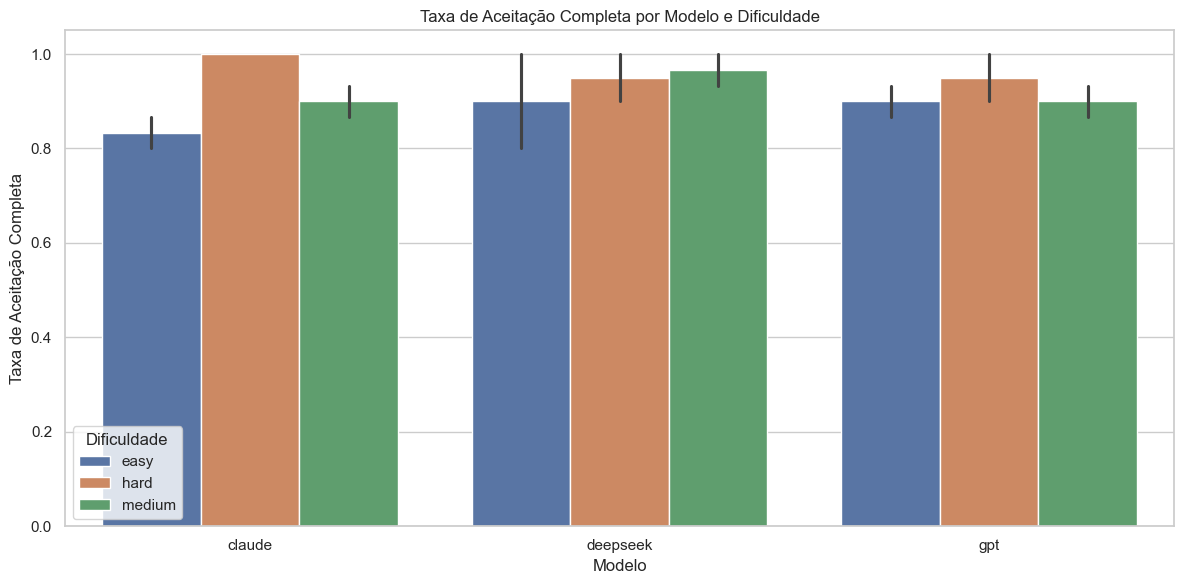

In [88]:
summary = df.groupby(['model', 'difficulty', 'language']).agg(
    total_submissions=('full_acceptance', 'count'),
    full_accept_rate=('full_acceptance', 'mean'),
    partial_accept_rate=('partial_acceptance', 'mean'),
    avg_runtime_ms=('runtime', 'mean'),
    avg_memory_bytes=('memory', 'mean')
).reset_index()

print(summary.head())

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='model', y='full_accept_rate', hue='difficulty')
plt.title('Taxa de Aceitação Completa por Modelo e Dificuldade')
plt.xlabel('Modelo')
plt.ylabel('Taxa de Aceitação Completa')
plt.xticks()
plt.legend(title='Dificuldade')
plt.tight_layout()
plt.show()

In [89]:
qualitative_samples = df[df['full_acceptance']].groupby(['model', 'difficulty']).apply(
    lambda x: x.nsmallest(3, 'runtime')
).reset_index(drop=True)

qualitative_samples[['model', 'difficulty', 'language', 'code', 'problem']].to_csv('qualitative_samples.csv', index=True)

C:\Users\henri\AppData\Local\Temp\ipykernel_13208\3960793886.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qualitative_samples = df[df['full_acceptance']].groupby(['model', 'difficulty']).apply(


In [90]:
memory_summary = df.groupby(['model', 'difficulty', 'language']).agg(
    avg_memory_percentile=('memory_percentile', 'mean'),
    count_submissions=('memory_percentile', 'count')
).reset_index()

print(memory_summary)


       model difficulty language  avg_memory_percentile  count_submissions
0     claude       easy        c              60.051067                 12
1     claude       easy  python3              52.254192                 13
2     claude       hard        c              64.227270                 10
3     claude       hard  python3              56.644820                 10
4     claude     medium        c              53.622429                 14
5     claude     medium  python3              51.787392                 13
6   deepseek       easy        c              41.113350                 12
7   deepseek       easy  python3              67.271467                 15
8   deepseek       hard        c              55.315144                  9
9   deepseek       hard  python3              60.948430                 10
10  deepseek     medium        c              46.092243                 14
11  deepseek     medium  python3              43.701680                 15
12       gpt       easy  

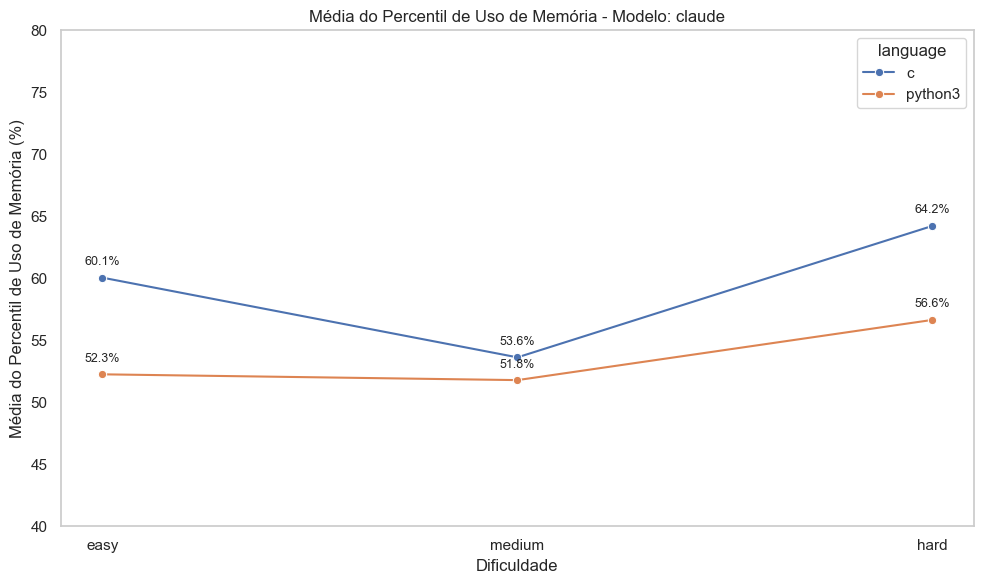

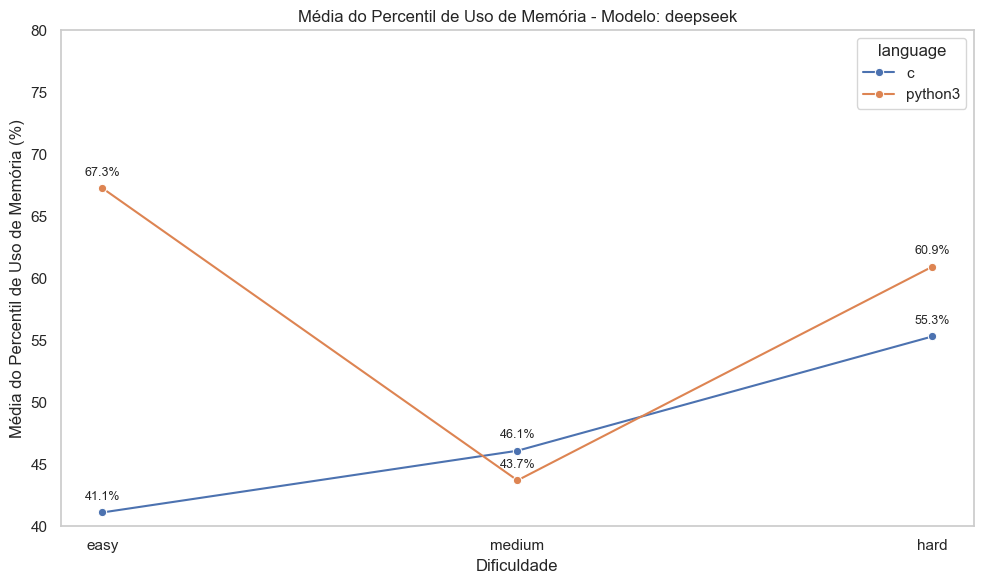

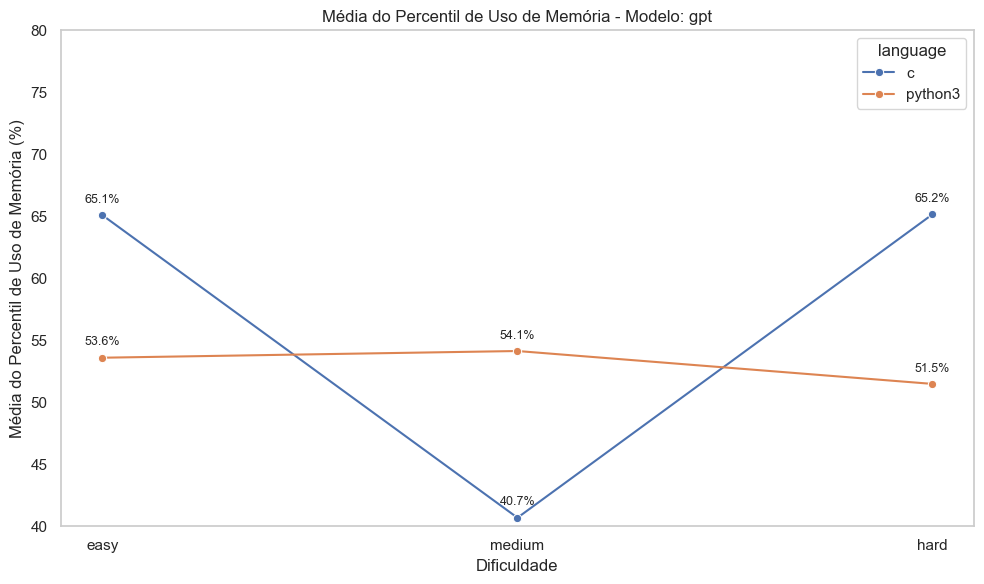

In [91]:
for model in memory_summary['model'].unique():
    plt.figure(figsize=(10, 6))
    subset = memory_summary[memory_summary['model'] == model].copy()
    difficulty_order = ['easy', 'medium', 'hard']
    subset['difficulty'] = pd.Categorical(subset['difficulty'], categories=difficulty_order, ordered=True)
    subset = subset.sort_values('difficulty')
    sns.lineplot(
        data=subset,
        x='difficulty',
        y='avg_memory_percentile',
        hue='language',
        marker='o',
        errorbar=None
    )
    for language in subset['language'].unique():
        lang_subset = subset[subset['language'] == language]
        for _, row in lang_subset.iterrows():
            plt.text(
                x=row['difficulty'],
                y=row['avg_memory_percentile'] + 1,
                s=f"{row['avg_memory_percentile']:.1f}%",
                ha='center',
                fontsize=9
            )
    plt.title(f'Média do Percentil de Uso de Memória - Modelo: {model}')
    plt.ylabel('Média do Percentil de Uso de Memória (%)')
    plt.xlabel('Dificuldade')
    plt.ylim(40, 80)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [92]:
runtime_summary = df.groupby(['model', 'difficulty', 'language']).agg(
    avg_runtime_percentile=('runtime_percentile', 'mean'),
    count_submissions=('runtime_percentile', 'count')
).reset_index()

print(runtime_summary)


       model difficulty language  avg_runtime_percentile  count_submissions
0     claude       easy        c               97.031100                 12
1     claude       easy  python3               80.224285                 13
2     claude       hard        c               89.165700                 10
3     claude       hard  python3               63.908740                 10
4     claude     medium        c               65.305593                 14
5     claude     medium  python3               69.826246                 13
6   deepseek       easy        c               97.031100                 12
7   deepseek       easy  python3               89.781967                 15
8   deepseek       hard        c               83.418856                  9
9   deepseek       hard  python3               81.709470                 10
10  deepseek     medium        c               80.918793                 14
11  deepseek     medium  python3               82.778200                 15
12       gpt

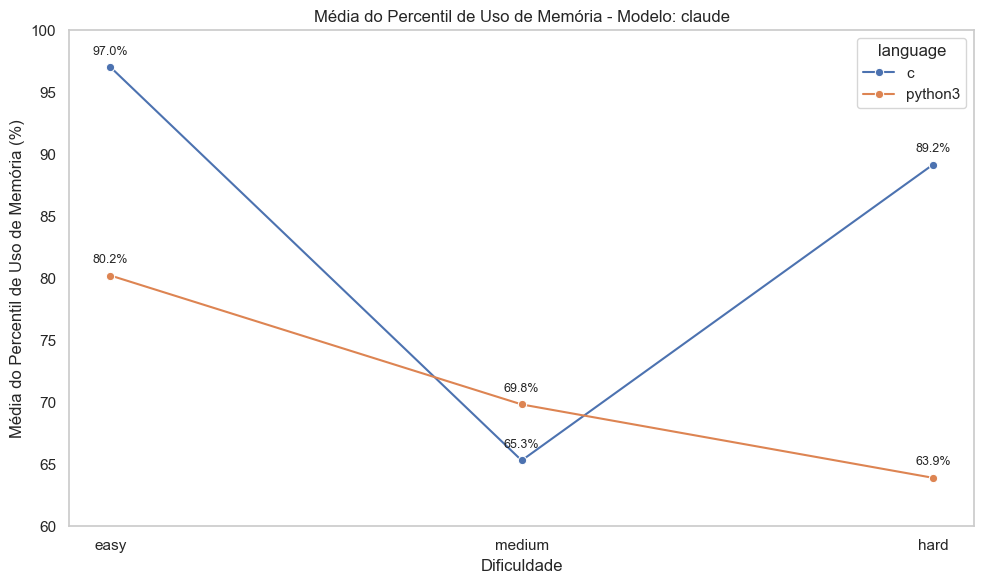

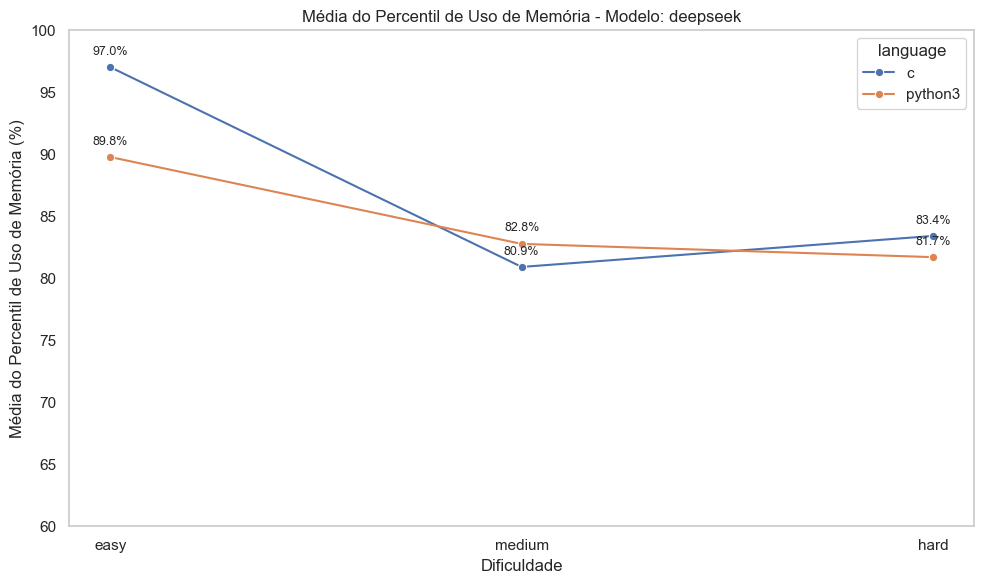

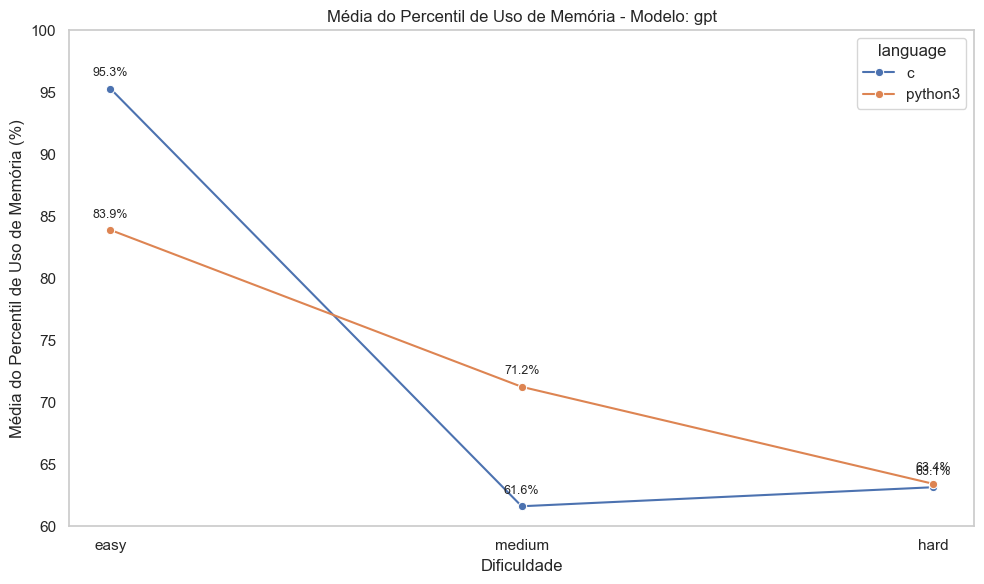

In [93]:
for model in runtime_summary['model'].unique():
    plt.figure(figsize=(10, 6))
    subset = runtime_summary[runtime_summary['model'] == model].copy()
    difficulty_order = ['easy', 'medium', 'hard']
    subset['difficulty'] = pd.Categorical(subset['difficulty'], categories=difficulty_order, ordered=True)
    subset = subset.sort_values('difficulty')
    sns.lineplot(
        data=subset,
        x='difficulty',
        y='avg_runtime_percentile',
        hue='language',
        marker='o',
        errorbar=None
    )
    for language in subset['language'].unique():
        lang_subset = subset[subset['language'] == language]
        for _, row in lang_subset.iterrows():
            plt.text(
                x=row['difficulty'],
                y=row['avg_runtime_percentile'] + 1,
                s=f"{row['avg_runtime_percentile']:.1f}%",
                ha='center',
                fontsize=9
            )
    plt.title(f'Média do Percentil de Uso de Memória - Modelo: {model}')
    plt.ylabel('Média do Percentil de Uso de Memória (%)')
    plt.xlabel('Dificuldade')
    plt.ylim(60, 100)
    plt.grid(False)
    plt.tight_layout()
    plt.show()